In [5]:
%pip install shap

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import shap
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore')


g:\Tnxs\kifiya5\week-3\Insurance-risk-analytics-predictive-modeling\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [52]:
from sklearn.impute import SimpleImputer

In [3]:

# Load data
df = pd.read_csv('data/MachineLearningRating_v3.txt', sep='\t')
df = pd.read_csv('data/MachineLearningRating_v3.txt', sep='|')

In [6]:
# Subset for claim severity
df_severity = df[df['TotalClaims'] > 0].copy()

# Impute missing values
for col in ['TotalPremium', 'CustomValueEstimate', 'CapitalOutstanding']:
    if df_severity[col].dtype == 'O':
        # Try to convert to numeric if possible
        df_severity[col] = pd.to_numeric(df_severity[col], errors='coerce')
    df_severity[col].fillna(df_severity[col].median(), inplace=True)


In [7]:
df_severity

,UnderwrittenCoverID,PolicyID,TransactionMonth,IsVATRegistered,Citizenship,LegalType,Title,Language,Bank,AccountType,...,ExcessSelected,CoverCategory,CoverType,CoverGroup,Section,Product,StatutoryClass,StatutoryRiskType,TotalPremium,TotalClaims
203,46222,4044,2014-10-01 00:00:00,False,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Metered Taxis - R2000,Own damage,Own Damage,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,0.000000,2294.096491
284,82062,7174,2015-03-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,21.929825,2040.473684
1560,119591,8672,2015-04-01 00:00:00,False,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Metered Taxis - R2000,Own damage,Own Damage,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,1213.889211,46492.211754
1779,50193,283,2014-10-01 00:00:00,False,,Close Corporation,Mr,English,Standard Bank,Current account,...,Mobility - Taxi with value more than R100 000 ...,Own Damage,Own Damage,Comprehensive - Taxi,Motor Comprehensive,Mobility Commercial Cover: Monthly,Commercial,IFRS Constant,645.017456,26516.859649
1943,119582,8672,2015-04-01 00:00:00,False,,Close Corporation,Mr,English,First National Bank,Current account,...,No excess,Income Protector,Income Protector,Income Protector,Optional Extended Covers,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,74.561404,6140.350877
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
998512,263942,962,2015-07-01 00:00:00,False,ZA,Private company,Mr,English,First National Bank,Current account,...,Mobility - Windscreen (Feb2015),Windscreen (2015),Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Commercial Cover: Monthly,Commercial,IFRS Constant,0.000000,7996.535088
998848,937,138,2014-08-01 00:00:00,False,ZA,Private company,Mr,English,RMB Private Bank,Current account,...,Mobility - Taxi with value more than R100 000 ...,Own Damage,Own Damage,Comprehensive - Taxi,Motor Comprehensive,Mobility Commercial Cover: Monthly,Commercial,IFRS Constant,613.519737,40011.859649
999218,3255,394,2014-05-01 00:00:00,False,ZA,Private company,Mr,English,RMB Private Bank,Current account,...,Mobility - Taxi with value more than R100 000 ...,Own Damage,Own Damage,Comprehensive - Taxi,Motor Comprehensive,Mobility Commercial Cover: Monthly,Commercial,IFRS Constant,836.004912,101812.517544
999701,238713,20611,2015-07-01 00:00:00,False,ZA,Private company,Mr,English,RMB Private Bank,Current account,...,Mobility - Taxi with value more than R100 000 ...,Vehicle over R100 000,Own Damage,Motor Comprehensive,Motor Comprehensive,Bridge Taxi Finance: Monthly,Commercial,IFRS Constant,650.879211,155317.578947


In [ ]:

# Feature Engineering
df_severity['VehicleAge'] = 2015 - df_severity['RegistrationYear']
df_severity['LossRatio'] = df_severity['TotalClaims'] / df_severity['TotalPremium']
df_severity['PremiumPerSumInsured'] = df_severity['TotalPremium'] / df_severity['SumInsured']
df_severity['PowerToWeight'] = df_severity['kilowatts'] / df_severity['cubiccapacity']


In [10]:

# Encode categorical variables
categorical_cols = [
    'Province', 'PostalCode', 'Gender', 'VehicleType', 'CoverType',
    'make', 'Model', 'ExcessSelected', 'MainCrestaZone'
]
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_cats = pd.DataFrame(
    encoder.fit_transform(df_severity[categorical_cols]),
    columns=encoder.get_feature_names_out(categorical_cols)
)
df_severity = pd.concat([df_severity.drop(categorical_cols, axis=1).reset_index(drop=True), encoded_cats], axis=1)


In [11]:
categorical_cols

['Province',
 'PostalCode',
 'Gender',
 'VehicleType',
 'CoverType',
 'make',
 'Model',
 'ExcessSelected',
 'MainCrestaZone']

In [12]:
df_severity

,UnderwrittenCoverID,PolicyID,TransactionMonth,IsVATRegistered,Citizenship,LegalType,Title,Language,Bank,AccountType,...,MainCrestaZone_Karoo 1 (Northeast of Cape Town),"MainCrestaZone_Langkloof, Coast 2, Coast 1",MainCrestaZone_Natal,MainCrestaZone_Natal (Durban),MainCrestaZone_Oranje Free State,MainCrestaZone_Port Elizabeth,MainCrestaZone_Rand East,"MainCrestaZone_Tembu 2, Cape Mid 2, Cape Mid West, Tembu 1",MainCrestaZone_Transvaal (Pretoria),MainCrestaZone_Transvaal (all except Pretoria)
0,46222,4044,2014-10-01 00:00:00,False,,Close Corporation,Mr,English,First National Bank,Current account,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,82062,7174,2015-03-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,119591,8672,2015-04-01 00:00:00,False,,Close Corporation,Mr,English,First National Bank,Current account,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,50193,283,2014-10-01 00:00:00,False,,Close Corporation,Mr,English,Standard Bank,Current account,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,119582,8672,2015-04-01 00:00:00,False,,Close Corporation,Mr,English,First National Bank,Current account,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2783,263942,962,2015-07-01 00:00:00,False,ZA,Private company,Mr,English,First National Bank,Current account,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2784,937,138,2014-08-01 00:00:00,False,ZA,Private company,Mr,English,RMB Private Bank,Current account,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2785,3255,394,2014-05-01 00:00:00,False,ZA,Private company,Mr,English,RMB Private Bank,Current account,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2786,238713,20611,2015-07-01 00:00:00,False,ZA,Private company,Mr,English,RMB Private Bank,Current account,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:

# Select features
features = [
    col for col in df_severity.columns if col not in [
        'TotalClaims', 'TotalPremium', 'PolicyID', 'UnderwrittenCoverID',
        'TransactionMonth', 'VehicleIntroDate', 'LossRatio'
    ]
]

X = df_severity[features]
y = df_severity['TotalClaims']


In [46]:
# Identify categorical columns
categorical_cols = X.select_dtypes(include=['object']).columns

# One-hot encode categorical columns
X = pd.get_dummies(X, columns=categorical_cols)


In [53]:
# Impute missing values with the mean (you can also use 'median' or 'most_frequent')
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)

In [54]:
X

array([[0.000000e+00, 4.042080e+06, 2.011000e+03, ..., 1.000000e+00,
        1.000000e+00, 1.000000e+00],
       [1.000000e+00, 2.208920e+07, 2.006000e+03, ..., 1.000000e+00,
        1.000000e+00, 1.000000e+00],
       [0.000000e+00, 5.037006e+06, 2.014000e+03, ..., 1.000000e+00,
        1.000000e+00, 1.000000e+00],
       ...,
       [0.000000e+00, 2.285015e+07, 2.014000e+03, ..., 0.000000e+00,
        1.000000e+00, 1.000000e+00],
       [0.000000e+00, 2.284015e+07, 2.014000e+03, ..., 0.000000e+00,
        1.000000e+00, 1.000000e+00],
       [0.000000e+00, 6.000749e+07, 2.012000e+03, ..., 1.000000e+00,
        1.000000e+00, 1.000000e+00]], shape=(2788, 766))

In [55]:
y

0         2294.096491
1         2040.473684
2        46492.211754
3        26516.859649
4         6140.350877
            ...      
2783      7996.535088
2784     40011.859649
2785    101812.517544
2786    155317.578947
2787     28903.850877
Name: TotalClaims, Length: 2788, dtype: float64

In [56]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [59]:

# Model definitions
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42, n_estimators=100),
    'XGBoost': XGBRegressor(random_state=42, n_estimators=100)
}


In [67]:
results

{'Linear Regression': {'RMSE': np.float64(38948.864164439874),
  'R2': 0.056728794388303694},
 'Random Forest': {'RMSE': np.float64(39826.85901367462),
  'R2': 0.013722566704899686},
 'XGBoost': {'RMSE': np.float64(40887.88996831382),
  'R2': -0.03952845412066197}}

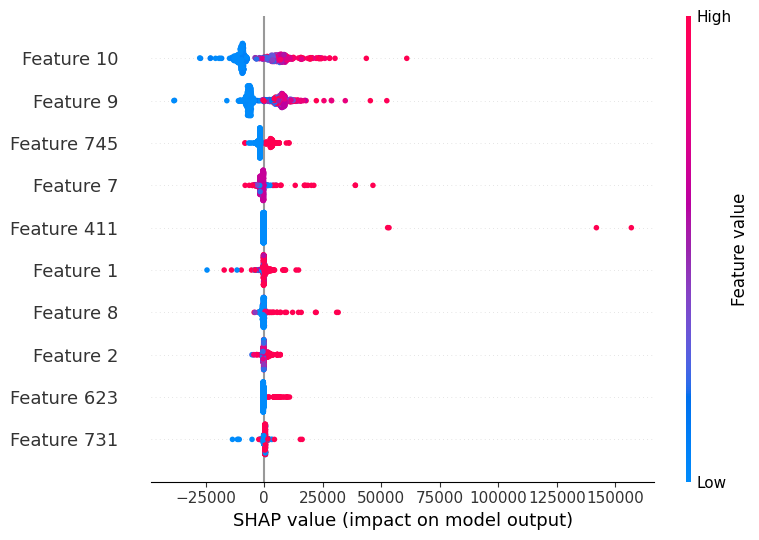

In [68]:

if name == 'XGBoost':
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)
    plt.figure(figsize=(16, 10))
    # Use X_test.columns if X_test is a DataFrame, otherwise omit feature_names
    shap.summary_plot(
        shap_values, 
        X_test, 
        feature_names=getattr(X_test, 'columns', None),  # Safely get columns if available
        show=False, 
        max_display=10
    )
    plt.show()